In [1]:
#%matplotlib nbagg   # networkx plotting doesn't seem to work with nbagg
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import reaclib

## Loading a single rate

In [5]:
r = reaclib.Rate("reaclib-rates/c13-pg-n14-nacr")

### the original reaclib source

In [7]:
print(r.original_source)

4                                                                         
                                                                          
                                                                          
         p  c13  n14                       nacrn     7.55100e+00          
 1.851550e+01 0.000000e+00-1.372000e+01-4.500180e-01                      
 3.708230e+00-1.705450e+00-6.666670e-01                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.396370e+01-5.781470e+00 0.000000e+00-1.967030e-01                      
 1.421260e-01-2.389120e-02-1.500000e+00                                   
         p  c13  n14                       nacrr     7.55100e+00          
 1.518250e+01-1.355430e+01 0.000000e+00 0.000000e+00                      
 0.000000e+00 0.000000e+00-1.500000e+00                                   



### evaluate the rate at a given temperature (in K)

In [8]:
r.eval(1.e9)

3883.4778216250666

### a human readable string describing the rate, and the nuclei involved

In [10]:
print(r)

p + c13 --> n14


In [11]:
print(r.reactants)
print(r.products)

[p, c13]
[n14]


### get the temperature sensitivity about some reference T

This is the exponent when we write the rate as $r = r_0 \left ( \frac{T}{T_0} \right )^\nu$

In [12]:
print(r.get_rate_exponent(2.e7))

16.2108967071


### plot the rate's temperature dependence

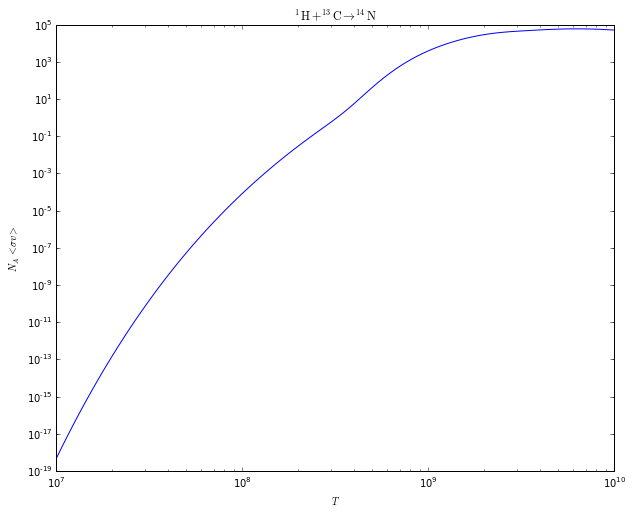

In [13]:
r.plot()

### the form of the rate with density and composition weighting -- this is what appears in a dY/dt equation

In [14]:
print(r.ydot_string())

rho*Y[ip]*Y[ic13]*lambda_c13_pg_n14


### output a python function that can evaluate the rate (T-dependence part)

In [15]:
print(r.function_string())

def c13_pg_n14(tf):
    # p + c13 --> n14
    rate = 0.0
    
    # nacrn
    rate += np.exp(  18.5155 + -13.72*tf.T913i + -0.450018*tf.T913
                  + 3.70823*tf.T9 + -1.70545*tf.T953 + -0.666667*tf.lnT9)
    # nacrr
    rate += np.exp(  13.9637 + -5.78147*tf.T9i + -0.196703*tf.T913
                  + 0.142126*tf.T9 + -0.0238912*tf.T953 + -1.5*tf.lnT9)
    # nacrr
    rate += np.exp(  15.1825 + -13.5543*tf.T9i
                  + -1.5*tf.lnT9)
    
    return rate




## working with a group of rates

In [18]:
files = ["c12-pg-n13-ls09", 
         "c13-pg-n14-nacr",
         "n13--c13-wc12",
         "n13-pg-o14-lg06",
         "n14-pg-o15-im05",
         "n15-pa-c12-nacr",
         "o14--n14-wc12",
         "o15--n15-wc12"]
rc = reaclib.RateCollection(files)

### print an overview of the network described by this rate collection

In [19]:
print(rc)

p + c12 --> n13
p + c13 --> n14
n13 --> c13
p + n13 --> o14
p + n14 --> o15
p + n15 --> he4 + c12
o14 --> n14
o15 --> n15



In [20]:
rc.print_network_overview()

p
  consumed by: 
     p + c12 --> n13 : rho*Y[ic12]*Y[ip]*lambda_c12_pg_n13
     p + c13 --> n14 : rho*Y[ip]*Y[ic13]*lambda_c13_pg_n14
     p + n13 --> o14 : rho*Y[ip]*Y[in13]*lambda_n13_pg_o14
     p + n14 --> o15 : rho*Y[ip]*Y[in14]*lambda_n14_pg_o15
     p + n15 --> he4 + c12 : rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
  produced by: 
 
he4
  consumed by: 
  produced by: 
     p + n15 --> he4 + c12 : rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
 
c12
  consumed by: 
     p + c12 --> n13 : rho*Y[ic12]*Y[ip]*lambda_c12_pg_n13
  produced by: 
     p + n15 --> he4 + c12 : rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
 
c13
  consumed by: 
     p + c13 --> n14 : rho*Y[ip]*Y[ic13]*lambda_c13_pg_n14
  produced by: 
     n13 --> c13 : Y[in13]*lambda_n13_c13
 
n13
  consumed by: 
     n13 --> c13 : Y[in13]*lambda_n13_c13
     p + n13 --> o14 : rho*Y[ip]*Y[in13]*lambda_n13_pg_o14
  produced by: 
     p + c12 --> n13 : rho*Y[ic12]*Y[ip]*lambda_c12_pg_n13
 
n14
  consumed by: 
     p + n14 --> o15 : rho*Y[ip]*Y[in14]*

### show a network diagram

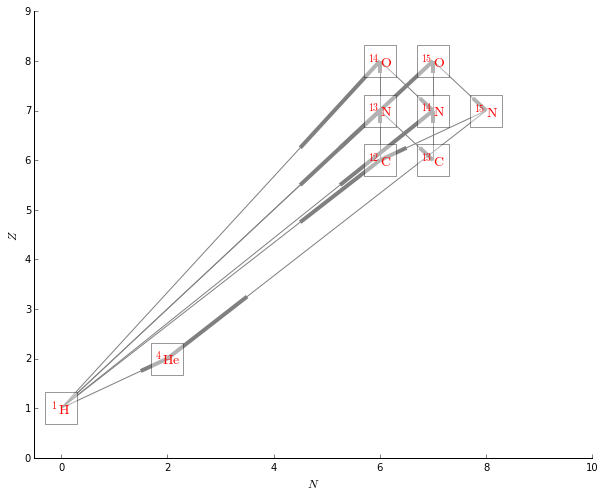

In [21]:
rc.plot()

### 

### write a function containing the ODEs that evolve this network

In [22]:
rc.make_network("test.py")

In [ ]:
# %load test.py
import numpy as np
import reaclib

ip = 0
ihe4 = 1
ic12 = 2
ic13 = 3
in13 = 4
in14 = 5
in15 = 6
io14 = 7
io15 = 8
nnuc = 9

A = np.zeros((nnuc), dtype=np.int32)

A[ip] = 1
A[ihe4] = 4
A[ic12] = 12
A[ic13] = 13
A[in13] = 13
A[in14] = 14
A[in15] = 15
A[io14] = 14
A[io15] = 15

def o15_n15(tf):
    # o15 --> n15
    rate = 0.0
    
    # wc12w
    rate += np.exp(  -5.17053)
    
    return rate

def n15_pa_c12(tf):
    # p + n15 --> he4 + c12
    rate = 0.0
    
    # nacrn
    rate += np.exp(  27.4764 + -15.253*tf.T913i + 1.59318*tf.T913
                  + 2.4479*tf.T9 + -2.19708*tf.T953 + -0.666667*tf.lnT9)
    # nacrr
    rate += np.exp(  -6.57522 + -1.1638*tf.T9i + 22.7105*tf.T913
                  + -2.90707*tf.T9 + 0.205754*tf.T953 + -1.5*tf.lnT9)
    # nacrr
    rate += np.exp(  20.8972 + -7.406*tf.T9i
                  + -1.5*tf.lnT9)
    # nacrr
    rate += np.exp(  -4.87347 + -2.02117*tf.T9i + 30.8497*tf.T913
                  + -8.50433*tf.T9 + -1.54426*tf.T953 + -1.5*tf.lnT9)
    
    return rate

def c13_pg_n14(tf):
    # p + c13 --> n14
    rate = 0.0
    
    # nacrn
    rate += np.exp(  18.5155 + -13.72*tf.T913i + -0.450018*tf.T913
                  + 3.70823*tf.T9 + -1.70545*tf.T953 + -0.666667*tf.lnT9)
    # nacrr
    rate += np.exp(  13.9637 + -5.78147*tf.T9i + -0.196703*tf.T913
                  + 0.142126*tf.T9 + -0.0238912*tf.T953 + -1.5*tf.lnT9)
    # nacrr
    rate += np.exp(  15.1825 + -13.5543*tf.T9i
                  + -1.5*tf.lnT9)
    
    return rate

def c12_pg_n13(tf):
    # p + c12 --> n13
    rate = 0.0
    
    # ls09n
    rate += np.exp(  17.1482 + -13.692*tf.T913i + -0.230881*tf.T913
                  + 4.44362*tf.T9 + -3.15898*tf.T953 + -0.666667*tf.lnT9)
    # ls09r
    rate += np.exp(  17.5428 + -3.77849*tf.T9i + -5.10735*tf.T913i + -2.24111*tf.T913
                  + 0.148883*tf.T9 + -1.5*tf.lnT9)
    
    return rate

def n13_pg_o14(tf):
    # p + n13 --> o14
    rate = 0.0
    
    # lg06n
    rate += np.exp(  18.1356 + -15.1676*tf.T913i + 0.0955166*tf.T913
                  + 3.0659*tf.T9 + -0.507339*tf.T953 + -0.666667*tf.lnT9)
    # lg06r
    rate += np.exp(  10.9971 + -6.12602*tf.T9i + 1.57122*tf.T913i
                  + -1.5*tf.lnT9)
    
    return rate

def n14_pg_o15(tf):
    # p + n14 --> o15
    rate = 0.0
    
    # im05n
    rate += np.exp(  17.01 + -15.193*tf.T913i + -0.161954*tf.T913
                  + -7.52123*tf.T9 + -0.987565*tf.T953 + -0.666667*tf.lnT9)
    # im05r
    rate += np.exp(  6.73578 + -4.891*tf.T9i
                  + 0.0682*tf.lnT9)
    # im05r
    rate += np.exp(  7.65444 + -2.998*tf.T9i
                  + -1.5*tf.lnT9)
    # im05n
    rate += np.exp(  20.1169 + -15.193*tf.T913i + -4.63975*tf.T913
                  + 9.73458*tf.T9 + -9.55051*tf.T953 + 0.333333*tf.lnT9)
    
    return rate

def o14_n14(tf):
    # o14 --> n14
    rate = 0.0
    
    # wc12w
    rate += np.exp(  -4.62354)
    
    return rate

def n13_c13(tf):
    # n13 --> c13
    rate = 0.0
    
    # wc12w
    rate += np.exp(  -6.7601)
    
    return rate

def rhs(t, Y, rho, T):

    tf = reaclib.Tfactors(T)

    lambda_o15_n15 = o15_n15(tf)
    lambda_n15_pa_c12 = n15_pa_c12(tf)
    lambda_c13_pg_n14 = c13_pg_n14(tf)
    lambda_c12_pg_n13 = c12_pg_n13(tf)
    lambda_n13_pg_o14 = n13_pg_o14(tf)
    lambda_n14_pg_o15 = n14_pg_o15(tf)
    lambda_o14_n14 = o14_n14(tf)
    lambda_n13_c13 = n13_c13(tf)

    dYdt = np.zeros((nnuc), dtype=np.float64)

    dYdt[ip] = (
       -rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
       -rho*Y[ic13]*Y[ip]*lambda_c13_pg_n14
       -rho*Y[ip]*Y[ic12]*lambda_c12_pg_n13
       -rho*Y[ip]*Y[in13]*lambda_n13_pg_o14
       -rho*Y[ip]*Y[in14]*lambda_n14_pg_o15
       )

    dYdt[ihe4] = (
       +rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
       )

    dYdt[ic12] = (
       -rho*Y[ip]*Y[ic12]*lambda_c12_pg_n13
       +rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
       )

    dYdt[ic13] = (
       -rho*Y[ic13]*Y[ip]*lambda_c13_pg_n14
       +Y[in13]*lambda_n13_c13
       )

    dYdt[in13] = (
       -rho*Y[ip]*Y[in13]*lambda_n13_pg_o14
       -Y[in13]*lambda_n13_c13
       +rho*Y[ip]*Y[ic12]*lambda_c12_pg_n13
       )

    dYdt[in14] = (
       -rho*Y[ip]*Y[in14]*lambda_n14_pg_o15
       +rho*Y[ic13]*Y[ip]*lambda_c13_pg_n14
       +Y[io14]*lambda_o14_n14
       )

    dYdt[in15] = (
       -rho*Y[ip]*Y[in15]*lambda_n15_pa_c12
       +Y[io15]*lambda_o15_n15
       )

    dYdt[io14] = (
       -Y[io14]*lambda_o14_n14
       +rho*Y[ip]*Y[in13]*lambda_n13_pg_o14
       )

    dYdt[io15] = (
       -Y[io15]*lambda_o15_n15
       +rho*Y[ip]*Y[in14]*lambda_n14_pg_o15
       )

    return dYdt
